In [5]:
import requests
import time
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

### Get the html and the dataframes


In [6]:
'''
Get all the tables from a page as a dataframe
'''

def html_tables_to_dataframes(html):

    # Analyze the html
    soup = bs(html, 'html.parser')
    
    # Find all the tables
    tables = soup.find_all('table')

    # List with final dataframes
    dataframes = []


    # Iterate for each table
    for table in tables:

        table_data = []

        # Iterate for each row 
        for row in table.find_all('tr'):

            data_columns =  row.find_all(['th','td'])
            row_data = [column.get_text(strip=True) for column in data_columns]
            table_data.append(row_data)

        df = pd.DataFrame(table_data)

        name_tables = df.iloc[0].to_list()

        # Save the name of headers as a name of columns        
        df.columns = name_tables
        df.drop(0, inplace=True)

        dataframes.append(df)
        

    return dataframes
    

Url from the webpage

In [7]:
url = "https://www.macrotrends.net/stocks/charts/TSLA/tesla/revenue" 

User-agent, we need to make the requests

In [8]:
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36"}
request = requests.get(url, headers = headers)

In [9]:
request = requests.get(url, headers = headers)

# time.sleep(1)

html = request.text


we see the tables that we have obtained

In [33]:
tesla_anual_revenue = html_tables_to_dataframes(html)[0]
tesla_quarterly_revenue = html_tables_to_dataframes(html)[1]
stocks_data = html_tables_to_dataframes(html)[3]

### Process the dataframes

In [35]:
tesla_quarterly_revenue.columns = ['quarterly', 'revenue']


In [36]:
tesla_quarterly_revenue['revenue'] = tesla_quarterly_revenue['revenue'].str.replace('$','')
tesla_quarterly_revenue['revenue'] = tesla_quarterly_revenue['revenue'].str.replace(',','')



In [37]:
tesla_quarterly_revenue['revenue'] = tesla_quarterly_revenue['revenue'].replace('', np.nan)

In [38]:
tesla_quarterly_revenue.dropna(inplace=True)

In [39]:
# Convert the quarterly to datetime format
tesla_quarterly_revenue['quarterly'] = pd.to_datetime(tesla_quarterly_revenue['quarterly'])

# sort by date
tesla_quarterly_revenue = tesla_quarterly_revenue.sort_values(by='quarterly')

# Format the dates
tesla_quarterly_revenue['quarterly'] = tesla_quarterly_revenue['quarterly'].dt.strftime('%d-%m-%Y')

In [40]:
tesla_quarterly_revenue

,quarterly,revenue
57,30-06-2009,27
56,30-09-2009,46
54,31-03-2010,21
53,30-06-2010,28
52,30-09-2010,31
51,31-12-2010,36
50,31-03-2011,49
49,30-06-2011,58
48,30-09-2011,58
47,31-12-2011,39


### Save in SQLite

In [17]:
# Connect to a sqlite
conexion = sqlite3.connect('../data/tesla.db')
cursor = conexion.cursor()

# Save in sqlite 
tesla_quarterly_revenue.to_sql('tesla_quarterly', conexion, if_exists='replace')

conexion.commit()
conexion.close()

### Visualize data

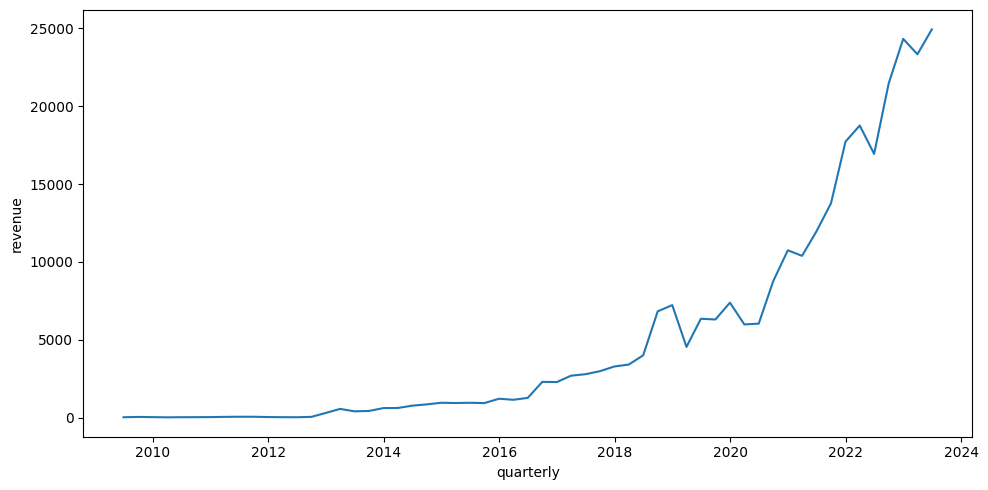

In [41]:

fig, axis = plt.subplots(figsize = (10, 5))

tesla_quarterly_revenue["quarterly"] = pd.to_datetime(tesla_quarterly_revenue["quarterly"],dayfirst=True)

tesla_quarterly_revenue["revenue"] = tesla_quarterly_revenue["revenue"].astype('int')

sns.lineplot(data = tesla_quarterly_revenue, x = "quarterly", y = "revenue",)


plt.tight_layout()

plt.show()

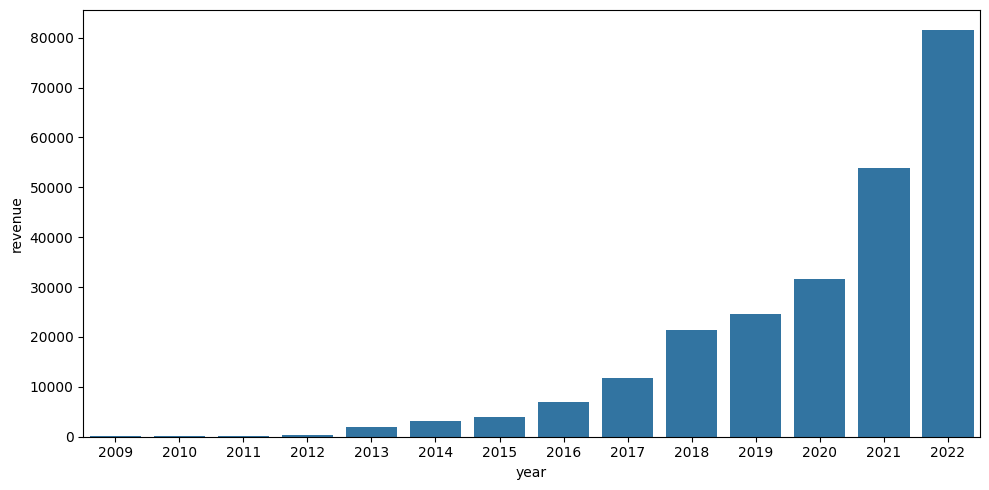

In [44]:
fig, axis = plt.subplots(figsize = (10, 5))

# Convert to datetime
tesla_quarterly_revenue["quarterly"] = pd.to_datetime(tesla_quarterly_revenue["quarterly"])

# Creates a new column with the year 
tesla_quarterly_revenue['year'] = tesla_quarterly_revenue['quarterly'].dt.year

# Group by year and sum the revenue
tesla_revenue_yearly = tesla_quarterly_revenue.groupby(["year"])['revenue'].sum().reset_index()


# Graphic the dataframe
sns.barplot(data = tesla_revenue_yearly[tesla_revenue_yearly["year"] < 2023], x = "year", y = "revenue")

plt.tight_layout()

plt.show()

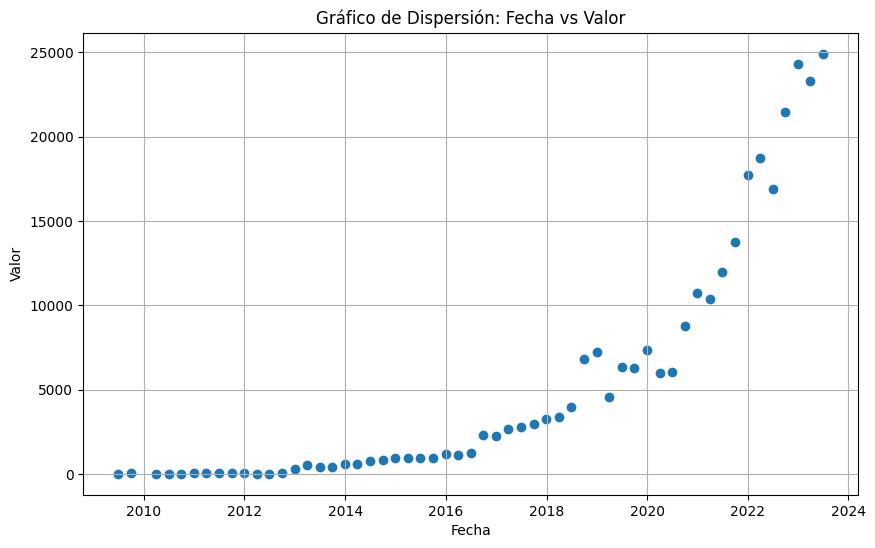

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(tesla_quarterly_revenue['quarterly'], tesla_quarterly_revenue['revenue'])
plt.title('Gráfico de Dispersión: Fecha vs Valor')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.grid(True)
plt.show()